<a href="https://colab.research.google.com/github/bismillahkani/grad-cam/blob/master/Grad_CAM_Code_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Module import

In [ ]:
import os
import PIL
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load image

In [ ]:
url = 'https://github.com/ramprs/grad-cam/blob/master/images/cat_dog.jpg?raw=true'

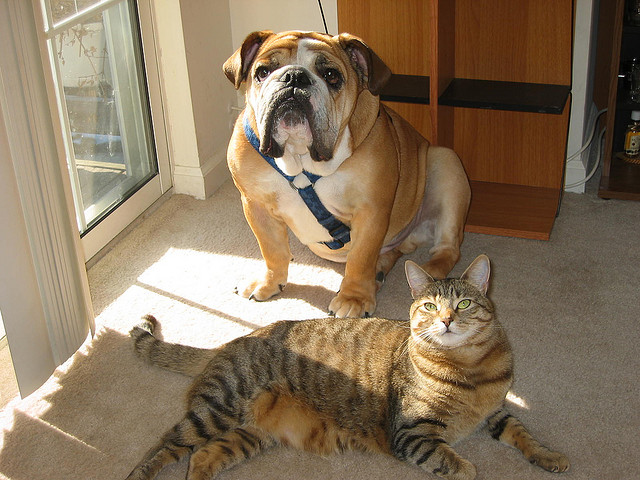

In [ ]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

### Preprocess image

In [ ]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

### Load torchvision models

In [ ]:
# alexnet = models.alexnet(pretrained=True)
# vgg = models.vgg16(pretrained=True)
resnet = models.resnet101(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# squeezenet = models.squeezenet1_1(pretrained=True)

In [ ]:
!wget 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

--2020-06-13 06:52:25--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2020-06-13 06:52:25 (2.16 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [ ]:
import ast
with open('imagenet1000_clsidx_to_labels.txt', 'r') as f:
  s = f.read()
  imagenet_classes = ast.literal_eval(s)

In the above image, there are two imagenet classes. 
1. Dog - imagenet class name : 'boxer', class index = 243
2. Cat - imagenet class name : 'tiger cat', class index = 283

In [ ]:
cls = 283

In [ ]:
imagenet_classes[cls-1] # zero index

'tiger cat'

### Grad-CAM 

Set-up Hooks

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

Step 1: compute the gradient of the score for class c

In [ ]:
with HookBwd(resnet._modules['layer4']) as hookg:
    with Hook(resnet._modules['layer4']) as hook:
        output = resnet.eval()(normed_torch_img)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

Step 2: global average pooling of the gradient >> neuron importance weights 

In [ ]:
w = grad[0].mean(dim=[1,2], keepdim=True)

Step 3: weighted combination of activation maps and ReLU

In [ ]:
cam_map = F.relu((w * act[0]).sum(0))

Visualization of Grad-CAM

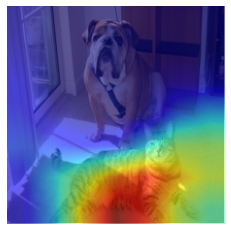

In [ ]:
image = torch_img.cpu().numpy().transpose(1,2,0)
_,ax = plt.subplots()
ax.imshow(image)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='jet')
ax.axis('off');

### Using Grad-CAM API

In [ ]:
!pip install pytorch-gradcam -q

In [ ]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [ ]:
configs = [
    # dict(model_type='alexnet', arch=alexnet, layer_name='features_11'),
    # dict(model_type='vgg', arch=vgg, layer_name='features_29'),
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
    # dict(model_type='densenet', arch=densenet, layer_name='features_norm5'),
    # dict(model_type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation')
]

In [ ]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

Visualization for class = 243 'boxer' dog

In [ ]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img, class_idx=243)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img, class_idx=243)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


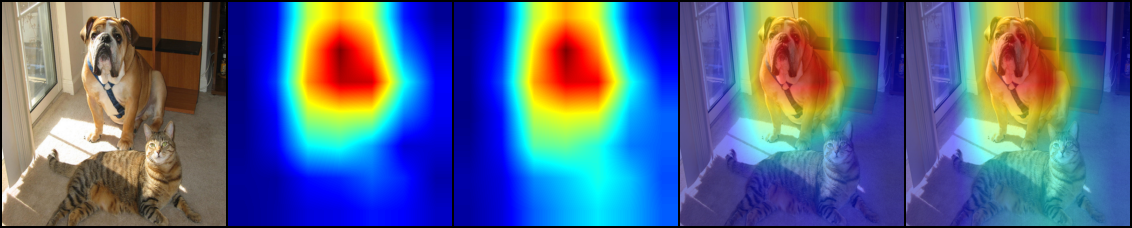

In [ ]:
transforms.ToPILImage()(grid_image)

Visualization for class = 283 'tiger cat'

In [ ]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img, class_idx=283)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img, class_idx=283)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


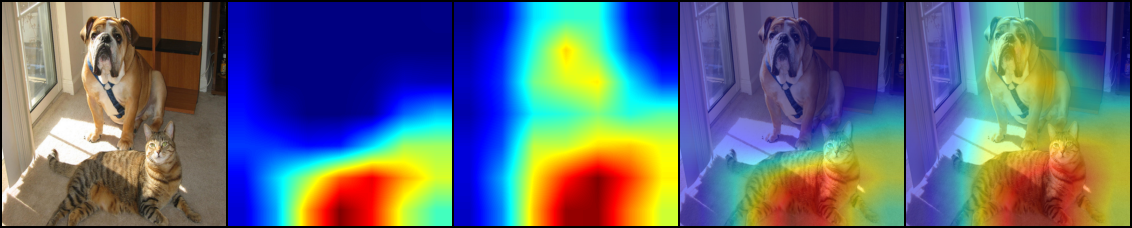

In [ ]:
transforms.ToPILImage()(grid_image)

Multi-occurence of same class

In [ ]:
url = 'https://github.com/vickyliin/gradcam_plus_plus-pytorch/blob/master/images/multiple_dogs.jpg?raw=true'

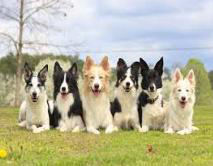

In [ ]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [ ]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [ ]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


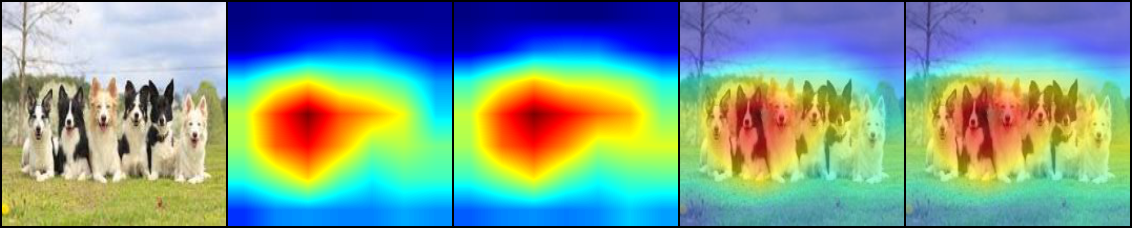

In [ ]:
transforms.ToPILImage()(grid_image)

### Guided Grad-CAM

In [ ]:
!git clone https://github.com/kazuto1011/grad-cam-pytorch

Cloning into 'grad-cam-pytorch'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 755 (delta 3), reused 3 (delta 0), pack-reused 744
Receiving objects: 100% (755/755), 43.59 MiB | 39.96 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [ ]:
%cd grad-cam-pytorch/

/content/grad-cam-pytorch/grad-cam-pytorch


In [ ]:
!python main.py demo1 -a resnet152 -t layer4 -k 1 -i ./samples/cat_dog.png

Mode: demo1
Device: CPU
Images:
	#0: ./samples/cat_dog.png
Vanilla Backpropagation:
	#0: boxer (0.35593)
Deconvolution:
	#0: boxer (0.35593)
Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
	#0: boxer (0.35593)


In [ ]:
results = os.listdir('./results')
results

['0-resnet152-deconvnet-boxer.png',
 '0-resnet152-guided-boxer.png',
 '0-resnet152-gradcam-layer4-boxer.png',
 '0-resnet152-guided_gradcam-layer4-boxer.png',
 '.gitignore',
 '0-resnet152-vanilla-boxer.png']

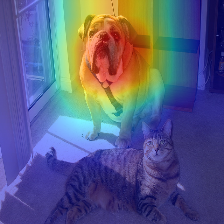

In [ ]:
img = Image.open('./results/'+results[2])
img

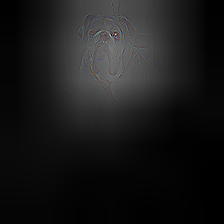

In [ ]:
img = Image.open('./results/'+results[3])
img